# Caprini Lellouch Neubert (CLN) parametrization

The CLN parametrization is used to describe the semileptonic decay $B^0 \longrightarrow D^{*-}\ell^+ \nu_{\ell}$ $(\ell = e, \mu)$ and a one-dimensional projection of the differential decay rate into the variables $w$, $cos(\theta_{l})$, $cos(\theta_{\nu})$ and $\chi$ is calculated. Each distribution is divided into 10 bins. For each bin, the number of expected events is calculated using the detector response matrix and the efficiency.

In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.integrate import quad

#import data
def import_mat4040(name):
    a = np.zeros(shape=(40,40))

    try:
        fobj = open(name)
        fobj.readline()
        fobj.readline()
        i=0
        j=0
        for line in fobj:
            x=line.split("=")
            a[i,j]=float(x[3])
            j=j+1
            if j > 39:
                i=i+1
                j=0

    except Exception as inst:
        print(inst)
    else:
        fobj.close()
    
    return a

def import_data(name):
    a = np.zeros(shape=(40))

    try:
        fobj = open(name)
        fobj.readline()
        fobj.readline()
        i=0
        
        for line in fobj:
            x=line.split("=")
            a[i]=float(x[2])
            i=i+1

    except Exception as inst:
        print(inst)
    else:
        fobj.close()
    
    return a

#Res_e=import_mat4040("Resp0.txt") #import detector response matrix
#epsilon_e = import_data("eff0.txt") #import efficiency
Res_e=np.identity(40)
epsilon_e=np.ones((40))*0.1

In [2]:
#CLN Parametrization
def z(w):
    return ((w+1.)**0.5-2.**0.5)/((w+1.)**0.5+2.**0.5)

def hA1(w,rho2):
    #hA1_1 = 0.906
    hA1_1 = 1.
    return hA1_1*(1.-8.*rho2*z(w)+(53.*rho2-15.)*z(w)**2.-(231.*rho2-91.)*z(w)**3.)

def R1(w,R1_1):
    return R1_1-0.12*(w-1.)+0.05*(w-1.)**2.

def R2(w,R2_1):
    return R2_1+0.11*(w-1.)-0.06*(w-1.)**2.

def H0(w,para):
    rho2, R1_1, R2_1, Vcb = para
    mDs = 2.01
    mB = 5.279
    Rs = 2*np.sqrt(mB*mDs)/(mB+mDs)
    r = mDs/mB
    H0 = mB * Rs *(1.-r**2.) * (w+1.) /(2*np.sqrt(1.-2.*r*w+r**2)) *hA1(w,rho2)
    H0 = H0 * (1.+(1.-R2(w, R2_1))*(w-1.)/(1-r))
    return H0

def Hp(w,para):
    rho2, R1_1, R2_1, Vcb = para
    mDs = 2.01
    mB = 5.279
    r = mDs/mB
    Rs = 2*np.sqrt(mB*mDs)/(mB+mDs)
    r = mDs/mB
    Hp = mB * Rs *(1.-r**2.) * (w+1.) /(2*np.sqrt(1.-2.*r*w+r**2)) *hA1(w,rho2)
    Hp = Hp * np.sqrt(1.-2.*r*w+r**2.)/(1.-r) * (1.-R1(w,R1_1) * np.sqrt((w-1.)/(w+1.)))
    return Hp

def Hm(w,para):
    rho2, R1_1, R2_1, Vcb = para
    mDs = 2.01
    mB = 5.279
    r = mDs/mB
    Rs = 2*np.sqrt(mB*mDs)/(mB+mDs)
    r = mDs/mB
    Hp = mB * Rs *(1.-r**2.) * (w+1.) /(2*np.sqrt(1.-2.*r*w+r**2)) *hA1(w,rho2)
    Hp = Hp * np.sqrt(1.-2.*r*w+r**2.)/(1.-r) * (1.+R1(w,R1_1) * np.sqrt((w-1.)/(w+1.)))
    return Hp

#Integral (1-cos(theta_l))^2
def Il1(a,b):
    return b-b**2.+b**3./3.-(a-a**2.+a**3./3.)

#Integral (1+cos(theta_l))^2
def Il2(a,b):
    return b+b**2.+b**3./3.-(a+a**2.+a**3./3.)

#Integral 1-cos(theta_l)^2
def Il3(a,b):
    return b-b**3./3.-(a-a**3./3.)

#Integral 1-cos(theta_l)^2
def Il4(a,b):
    return b-b**3./3.-(a-a**3./3.)

#Integral 1-cos(theta_nu)^2
def In1(a,b):
    return b-b**3./3.-(a-a**3./3.)

#Integral 1-cos(theta_nu)^2
def In2(a,b):
    return b-b**3./3.-(a-a**3./3.)

#Integral cos(theta_nu)^2
def In3(a,b):
    return b**3./3.-(a**3./3.)

#Integral 1-cos(theta_nu)^2
def In4(a,b):
    return b-b**3./3.-(a-a**3./3.)

#Integral 1
def Ic1(a,b):
    return b-a

#Integral 1
def Ic2(a,b):
    return b-a

#Integral 1
def Ic3(a,b):
    return b-a

#Integral cos(2*chi)
def Ic4(a,b):
    return 0.5*np.sin(2.*b)-0.5*np.sin(2.*a)

#Integral sqrt(w^2-1)*(1.-2.*w*r+r**2)*Hp^2
def w1(w, para):
    mDs = 2.01
    mB = 5.279
    r = mDs/mB
    return np.sqrt(w**2-1.)*(1.-2.*w*r+r**2)*Hp(w,para)**2

def Iw1(a,b,para):
    I = quad(w1, a, b, args=(para))
    return I[0]

#Integral sqrt(w^2-1)*(1.-2.*w*r+r**2)*Hm^2
def w2(w, para):
    mDs = 2.01
    mB = 5.279
    r = mDs/mB
    return np.sqrt(w**2-1.)*(1.-2.*w*r+r**2)*Hm(w,para)**2

def Iw2(a,b,para):
    I = quad(w2, a, b, args=(para))
    return I[0]

#Integral 4*sqrt(w^2-1)*(1.-2.*w*r+r**2)*H0^2
def w3(w, para):
    mDs = 2.01
    mB = 5.279
    r = mDs/mB
    return 4.*np.sqrt(w**2-1.)*(1.-2.*w*r+r**2)*H0(w,para)**2

def Iw3(a,b,para):
    I = quad(w3, a, b, args=(para))
    return I[0]

#Integral -2*sqrt(w^2-1)*(1.-2.*w*r+r**2)*Hp*Hm
def w4(w, para):
    mDs = 2.01
    mB = 5.279
    r = mDs/mB
    return -2.*np.sqrt(w**2-1.)*(1.-2.*w*r+r**2)*Hp(w,para)*Hm(w,para)

def Iw4(a,b,para):
    I = quad(w4, a, b, args=(para))
    return I[0]

#Integral from cos(theta_l)=-1 to cos(theta_l)=1
Il = np.zeros(shape=(4))
Il[0]=Il1(-1.,1.) #term 1
Il[1]=Il2(-1.,1.) #term 2
Il[2]=Il3(-1.,1.) #term 3
Il[3]=Il4(-1.,1.) #term 4

#Integral from cos(theta_nu)=-1 to cos(theta_nu)=1
In = np.zeros(shape=(4))
In[0]=In1(-1.,1.) #term 1
In[1]=In2(-1.,1.) #term 2
In[2]=In3(-1.,1.) #term 3
In[3]=In4(-1.,1.) #term 4

#Integral from chi=-Pi to chi=Pi
Ic = np.zeros(shape=(4))
Ic[0]=Ic1(-np.pi,np.pi) #term 1
Ic[1]=Ic2(-np.pi,np.pi) #term 2
Ic[2]=Ic3(-np.pi,np.pi) #term 3
Ic[3]=Ic4(-np.pi,np.pi) #term 4

#Integral from cos(theta_l)=-1 to -0.8, -0.8 to -0.6, -0.6 to -0.4, ...
Il_10 = np.zeros(shape=(4,10))
for m in range(0, 10):
    Il_10[0,m]=Il1(m*0.2-1.,m*0.2-0.8) #term 1
for m in range(0, 10):
    Il_10[1,m]=Il2(m*0.2-1.,m*0.2-0.8) #term 2
for m in range(0, 10):
    Il_10[2,m]=Il3(m*0.2-1.,m*0.2-0.8) #term 3
for m in range(0, 10):
    Il_10[3,m]=Il4(m*0.2-1.,m*0.2-0.8) #term 4

#Integral from cos(theta_n)=-1 to -0.8, -0.8 to -0.6, -0.6 to -0.4, ...
In_10 = np.zeros(shape=(4,10))
for m in range(0, 10):
    In_10[0,m]=In1(m*0.2-1.,m*0.2-0.8) #term 1
for m in range(0, 10):
    In_10[1,m]=In2(m*0.2-1.,m*0.2-0.8) #term 2
for m in range(0, 10):
    In_10[2,m]=In3(m*0.2-1.,m*0.2-0.8) #term 3
for m in range(0, 10):
    In_10[3,m]=In4(m*0.2-1.,m*0.2-0.8) #term 4

#Integral from chi=-Pi to -0.8*Pi, -0.8*Pi to -0.6*Pi, -0.6*Pi to -0.4*Pi, ...
Ic_10 = np.zeros(shape=(4,10))
for m in range(0, 10):
    Ic_10[0,m]=Ic1(m*0.2*np.pi-np.pi,m*0.2*np.pi-0.8*np.pi) #term 1
for m in range(0, 10):
    Ic_10[1,m]=Ic2(m*0.2*np.pi-np.pi,m*0.2*np.pi-0.8*np.pi) #term 2
for m in range(0, 10):
    Ic_10[2,m]=Ic3(m*0.2*np.pi-np.pi,m*0.2*np.pi-0.8*np.pi) #term 3
for m in range(0, 10):
    Ic_10[3,m]=Ic4(m*0.2*np.pi-np.pi,m*0.2*np.pi-0.8*np.pi) #term 4

#calculate number of expected events
def N_exp_e(para):
    N_exp = np.zeros(shape=(40))
    
    rho2, R1_1, R2_1, Vcb = para
    
    GF = 1.16637 * 10**(-5)
    mDs = 2.01
    mB = 5.279
    #eta_EW = 1.0066
    eta_EW = 1.
    r = mDs/mB
    
    #Integral from w=1.0 to 1.05, 1.05 to 1.10, 1.10 to 1.15, ...
    Iw_10 = np.zeros(shape=(4,10))
    for m in range(0, 10):
        Iw_10[0,m]=Iw1(m*0.05+1.,m*0.05+1.05,para) #term 1
    for m in range(0, 10):
        Iw_10[1,m]=Iw2(m*0.05+1.,m*0.05+1.05,para) #term 2
    for m in range(0, 10):
        Iw_10[2,m]=Iw3(m*0.05+1.,m*0.05+1.05,para) #term 3
    for m in range(0, 10):
        Iw_10[3,m]=Iw4(m*0.05+1.,m*0.05+1.05,para) #term 4
    
    #Integral from w=1.0 to w=1.5
    Iw = np.zeros(shape=(4))
    Iw[0] = sum(Iw_10[0,0:10]) #term 1
    Iw[1] = sum(Iw_10[1,0:10]) #term 2
    Iw[2] = sum(Iw_10[2,0:10]) #term 3
    Iw[3] = sum(Iw_10[3,0:10]) #term 4
    
    #calculate number of expected events bin 1..10
    for n in range(0,10):
        for m in range(0, 10):
            Int = 0.
            for o in range(0, 4): #sum over term 1 to 4
                Int = Int + Iw_10[o,m]*Il[o]*In[o]*Ic[o]
            N_exp[n] = N_exp[n] + Res_e[n,m] * epsilon_e[m]*Int
    
    #calculate number of expected events bin 11..20
    for n in range(10,20):
        for m in range(0, 10):
            Int = 0.
            for o in range(0, 4): #sum over term 1 to 4
                Int = Int + Iw[o]*Il_10[o,m]*In[o]*Ic[o]
            N_exp[n] = N_exp[n] + Res_e[n,(m+10)] * epsilon_e[(m+10)]*Int
    
    #calculate number of expected events bin 21..30
    for n in range(20,30):
        for m in range(0, 10):
            Int = 0.
            for o in range(0, 4): #sum over term 1 to 4
                Int = Int + Iw[o]*Il[o]*In_10[o,m]*Ic[o]
            N_exp[n] = N_exp[n] + Res_e[n,(m+20)] * epsilon_e[(m+20)]*Int
  
    #calculate number of expected events bin 31..40
    for n in range(30,40):
        for m in range(0, 10):
            Int = 0.
            for o in range(0, 4): #sum over term 1 to 4
                Int = Int + Iw[o]*Il[o]*In[o]*Ic_10[o,m]
            N_exp[n] = N_exp[n] + Res_e[n,(m+30)] * epsilon_e[(m+30)]*Int  
                
    N_exp = N_exp *771.581*10**6 * 0.677*0.0393 *(1519*10**(-15))  *2.* 0.486 /(6.58212 * 10**(-25))
    N_exp = N_exp *eta_EW**2. * 3 * mB * mDs**2. /(4.*(4.*np.pi)**4.) * GF**2. * Vcb**2.
    
    return N_exp

parameter: [1.166, 1.184, 0.848, 0.03648]


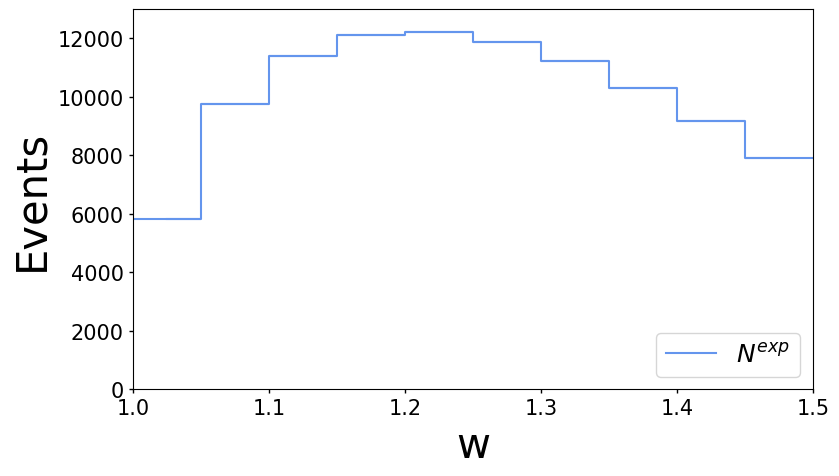

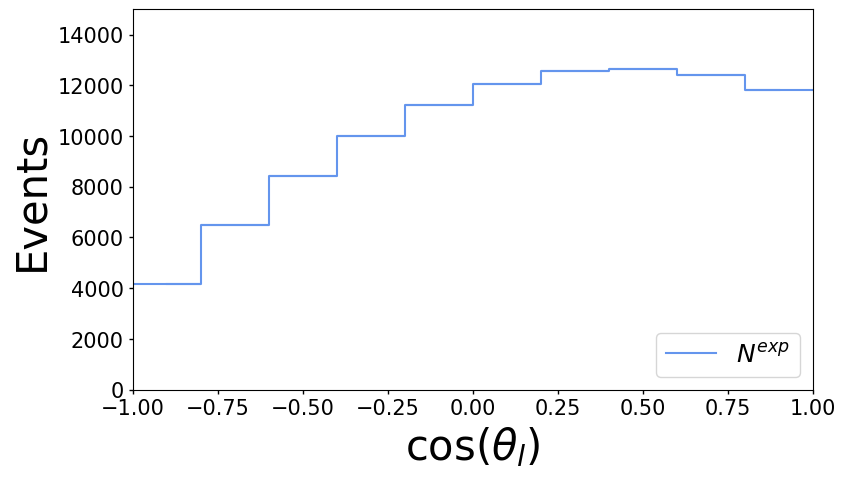

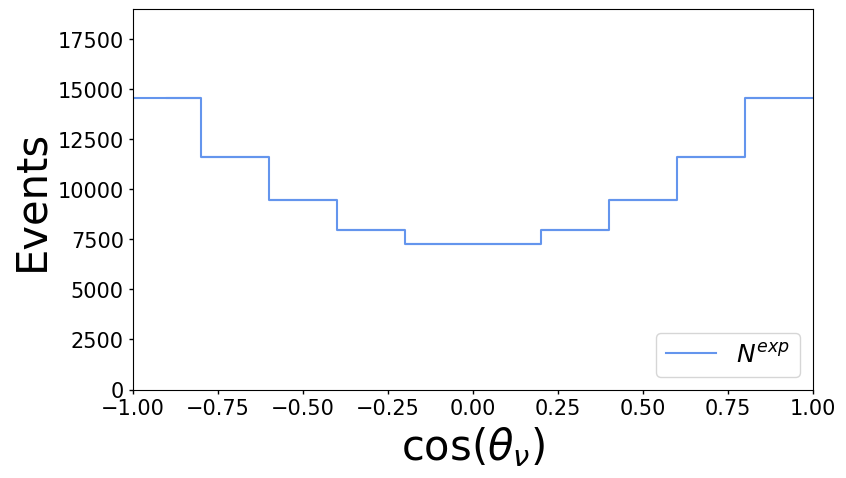

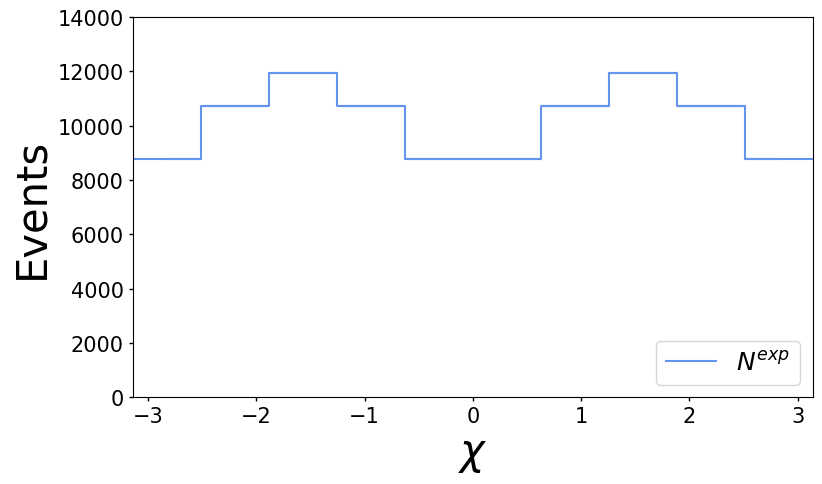

number of expected events:
[ 5823.92618833  9746.16423311 11410.51765749 12116.72547764
 12214.35163109 11878.02484298 11215.05906842 10299.57961772
  9187.05151433  7921.66450461  4182.00031541  6488.77449034
  8430.45052951 10007.02843294 11218.50820061 12064.88983254
 12546.17332871 12662.35868913 12413.44591381 11799.43500273
 14562.48410258 11641.69901657  9451.11020207  7990.71765907
  7260.52138757  7260.52138757  7990.71765907  9451.11020207
 11641.69901657 14562.48410258  8765.58745483 10722.06302021
 11931.23141777 10722.06302021  8765.58745483  8765.58745483
 10722.06302021 11931.23141777 10722.06302021  8765.58745483]


In [3]:
#Plot
result_1em=[1.166, 1.184, 0.848, 0.03648]

X1 = np.zeros(shape=(10))
X2 = np.zeros(shape=(10))
X3 = np.zeros(shape=(10))
for m in range(0, 10):
    X1[m]=m*0.5/10.+1.025
for m in range(0, 10):
    X2[m]=m*2./10.-0.9
for m in range(0, 10):
    X3[m]=m*2./10.*np.pi-0.9*np.pi

Nexp = N_exp_e(result_1em)


print("parameter:",result_1em)

figure = plt.gcf()
figure.set_size_inches(8.5,4.875)

lower_error = [0.025,]*10
upper_error = [0.025,]*10
asymmetric_error = [lower_error, upper_error]


plt.errorbar(X1, Nexp[0:10], xerr=asymmetric_error, fmt='none', color='cornflowerblue')
plt.step(X1, Nexp[0:10], where='mid', label=r'$N^{exp}$', color='cornflowerblue')

plt.tick_params(labelsize=15, width=1, length=3)
plt.ylim(0., 13000.)
plt.xlim(1., 1.5)
plt.xlabel("w", fontsize=30)
plt.ylabel("Events", fontsize=30)

legend = plt.legend(loc='lower right', shadow=False, fontsize='x-large', facecolor='white', prop={'size': 18})

plt.subplots_adjust(left=0.15, right=.95, bottom=0.17, top=0.95)

fname = "CLN_em1.png"

plt.savefig(fname, dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1)

plt.show()

figure = plt.gcf()
figure.set_size_inches(8.5,4.875)

lower_error = [0.1,]*10
upper_error = [0.1,]*10
asymmetric_error = [lower_error, upper_error]


plt.errorbar(X2, Nexp[10:20], xerr=asymmetric_error, fmt='none', color='cornflowerblue')
plt.step(X2, Nexp[10:20], where='mid', label=r'$N^{exp}$', color='cornflowerblue')

plt.tick_params(labelsize=15, width=1, length=3)
plt.ylim(0., 15000.)
plt.xlim(-1., 1.)
plt.xlabel(r'cos($\theta_l$)', fontsize=30)
plt.ylabel("Events", fontsize=30)

legend = plt.legend(loc='lower right', shadow=False, fontsize='x-large', facecolor='white', prop={'size': 18})

plt.subplots_adjust(left=0.15, right=.95, bottom=0.17, top=0.95)

fname = "CLN_em2.png"

plt.savefig(fname, dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1)

plt.show()

figure = plt.gcf()
figure.set_size_inches(8.5,4.875)


plt.errorbar(X2, Nexp[20:30], xerr=asymmetric_error, fmt='none', color='cornflowerblue')
plt.step(X2, Nexp[20:30], where='mid', label=r'$N^{exp}$', color='cornflowerblue')

plt.tick_params(labelsize=15, width=1, length=3)
plt.ylim(0., 19000.)
plt.xlim(-1., 1.)
plt.xlabel(r'cos($\theta_{\nu}$)', fontsize=30)
plt.ylabel("Events", fontsize=30)

legend = plt.legend(loc='lower right', shadow=False, fontsize='x-large', facecolor='white', prop={'size': 18})

plt.subplots_adjust(left=0.15, right=.95, bottom=0.17, top=0.95)

fname = "CLN_em3.png"

plt.savefig(fname, dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1)

plt.show()

figure = plt.gcf()
figure.set_size_inches(8.5,4.875)

lower_error = [0.1 * np.pi,]*10
upper_error = [0.1 * np.pi,]*10
asymmetric_error = [lower_error, upper_error]



plt.errorbar(X3, Nexp[30:40], xerr=asymmetric_error, fmt='none', color='cornflowerblue')
plt.step(X3, Nexp[30:40], where='mid', label=r'$N^{exp}$', color='cornflowerblue')

plt.tick_params(labelsize=15, width=1, length=3)
plt.ylim(0., 14000.)
plt.xlim(-np.pi, np.pi)
plt.xlabel(r'$\chi$', fontsize=30)
plt.ylabel("Events", fontsize=30)

legend = plt.legend(loc='lower right', shadow=False, fontsize='x-large', facecolor='white', prop={'size': 18})

plt.subplots_adjust(left=0.15, right=.95, bottom=0.17, top=0.95)

fname = "CLN_em4.png"

plt.savefig(fname, dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1)

plt.show()

print('number of expected events:')
print(Nexp)